<a href="https://colab.research.google.com/github/freirepablo/Mango_Leaf_Disease_Classification/blob/main/Inception_V3_(Cross-Validation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import layers, models, optimizers
from keras.optimizers import RMSprop
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Activation
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint

In [ ]:
train_path = '/content/drive/MyDrive/Dataset/Treino'
test_path = '/content/drive/MyDrive/Dataset/Validação'

In [ ]:
batch_size = 32
img_size = (224, 224)
epochs = 35

In [ ]:
folders = glob('/content/drive/MyDrive/Dataset/Treino/*')
labels = [os.path.basename(folder) for folder in folders]
print(labels)

['Antracnose', 'Cancro Bacteriano', 'Morte Descendente', 'Mosca das Galhas', 'Saudavel', 'Oidio', 'Mofo Fuliginoso']


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inceptionv3.layers:
    layer.trainable = False

x = inceptionv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=inceptionv3.input, outputs=predictions)

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for fold, (train_index, test_index) in enumerate(skf.split(folders, np.zeros(len(folders)))):
    print(f"Fold {fold + 1}")

    # Criar geradores de treino e teste para o fold atual
    #train_folders = np.array(folders)[train_index]
    #test_folders = np.array(folders)[test_index]

    train_generator = train_datagen.flow_from_directory(train_path,
                                                     target_size=(224, 224),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

    # Criar um novo modelo para cada fold
    model = Model(inputs=inceptionv3.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callback para salvar o melhor modelo para cada fold
    checkpoint = keras.callbacks.ModelCheckpoint(f'inceptionv3_fold_{fold + 1}.h5',
                                                    monitor='val_accuracy',
                                                    save_best_only=True,
                                                    mode='max',
                                                    verbose=1)

    # Treinar o modelo para o fold atual
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=test_generator,
                        callbacks=[checkpoint])

    # Limpar a sessão Keras para liberar memória
    keras.backend.clear_session()

Fold 1
Found 2550 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Epoch 1/35
80/80 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.7388 
Epoch 1: val_accuracy improved from -inf to 0.91000, saving model to inceptionv3_fold_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 1811s 23s/step - loss: 0.2678 - accuracy: 0.7388 - val_loss: 0.0819 - val_accuracy: 0.9100
Epoch 2/35
80/80 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.8973
Epoch 2: val_accuracy did not improve from 0.91000
80/80 [==============================] - 37s 464ms/step - loss: 0.0877 - accuracy: 0.8973 - val_loss: 0.1087 - val_accuracy: 0.8800
Epoch 3/35
80/80 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9286
Epoch 3: val_accuracy improved from 0.91000 to 0.91714, saving model to inceptionv3_fold_1.h5
80/80 [==============================] - 37s 466ms/step - loss: 0.0608 - accuracy: 0.9286 - val_loss: 0.0626 - val_accuracy: 0.9171
Epoch 4/35
80/80 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9471
Epoch 4: val_accuracy improved from 0.91714 to 0.96000, saving model to inceptionv3_fold_1.h5
80/80 [==============================] - 38s 472ms/step - loss: 0.0488 - accuracy: 

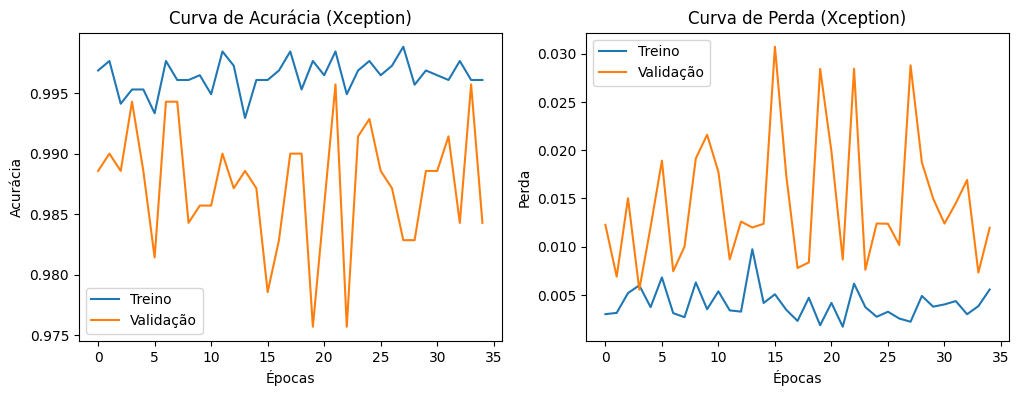

In [ ]:
# Plote as curvas de treino e teste
plt.figure(figsize=(12, 4))

# Plot da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia (Xception)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Plot da Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Perda (Xception)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

Found 339 images belonging to 7 classes.
11/11 [==============================] - 217s 22s/step


<Figure size 1000x800 with 0 Axes>

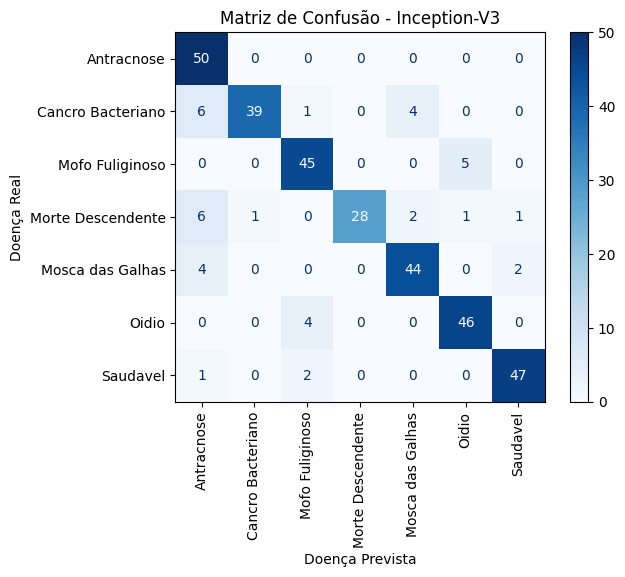

<Figure size 1000x800 with 0 Axes>

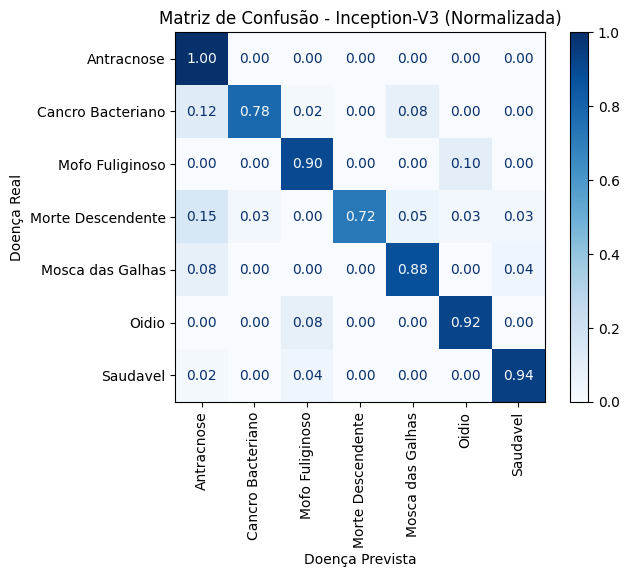

                   precision    recall  f1-score   support

       Antracnose       0.75      1.00      0.85        50
Cancro Bacteriano       0.97      0.78      0.87        50
  Mofo Fuliginoso       0.87      0.90      0.88        50
Morte Descendente       1.00      0.72      0.84        39
 Mosca das Galhas       0.88      0.88      0.88        50
            Oidio       0.88      0.92      0.90        50
         Saudavel       0.94      0.94      0.94        50

         accuracy                           0.88       339
        macro avg       0.90      0.88      0.88       339
     weighted avg       0.90      0.88      0.88       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/inceptionv3_fold_1.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 680ms/step


<Figure size 1000x800 with 0 Axes>

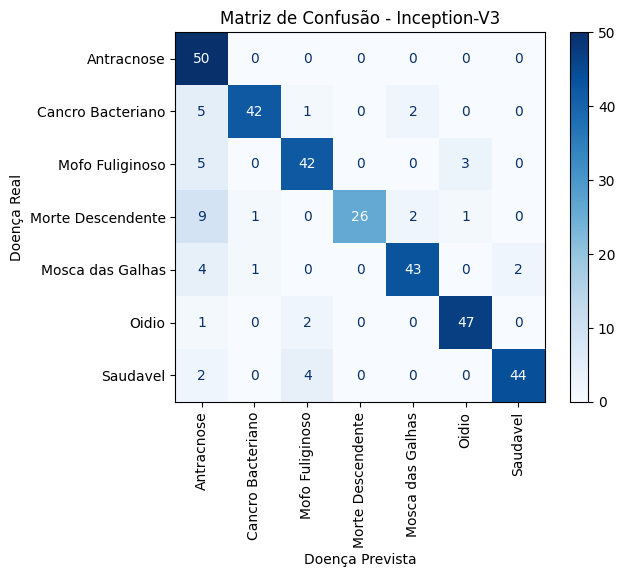

<Figure size 1000x800 with 0 Axes>

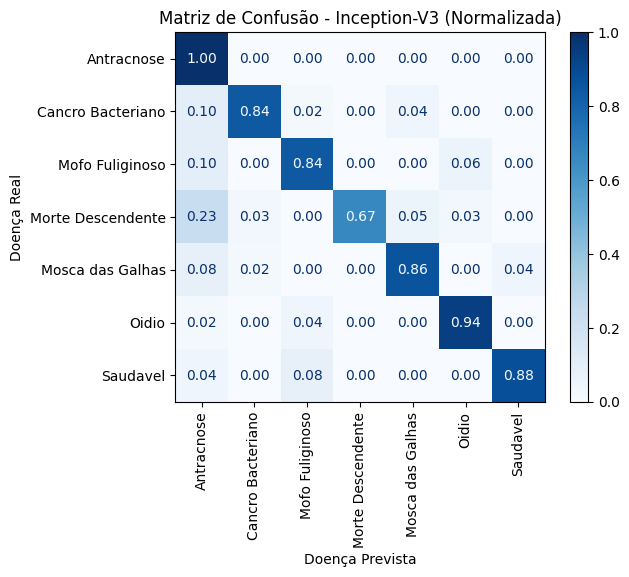

                   precision    recall  f1-score   support

       Antracnose       0.66      1.00      0.79        50
Cancro Bacteriano       0.95      0.84      0.89        50
  Mofo Fuliginoso       0.86      0.84      0.85        50
Morte Descendente       1.00      0.67      0.80        39
 Mosca das Galhas       0.91      0.86      0.89        50
            Oidio       0.92      0.94      0.93        50
         Saudavel       0.96      0.88      0.92        50

         accuracy                           0.87       339
        macro avg       0.89      0.86      0.87       339
     weighted avg       0.89      0.87      0.87       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/inceptionv3_fold_2.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 646ms/step


<Figure size 1000x800 with 0 Axes>

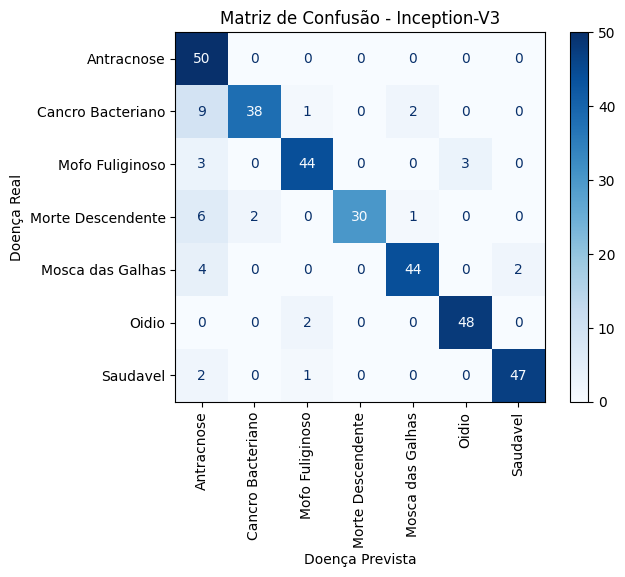

<Figure size 1000x800 with 0 Axes>

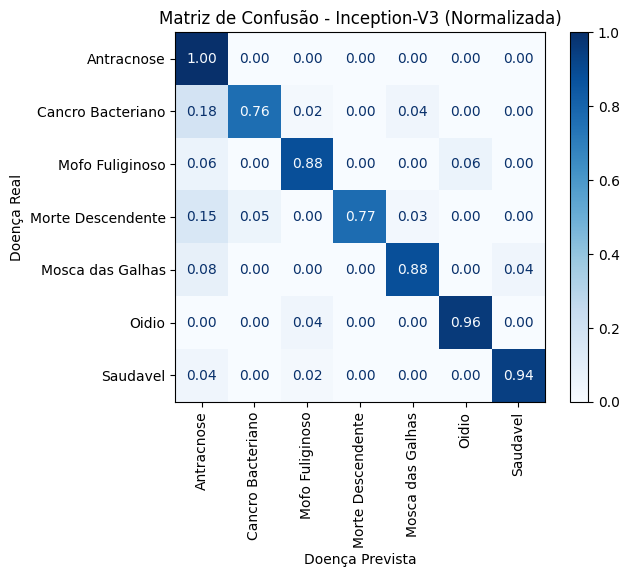

                   precision    recall  f1-score   support

       Antracnose       0.68      1.00      0.81        50
Cancro Bacteriano       0.95      0.76      0.84        50
  Mofo Fuliginoso       0.92      0.88      0.90        50
Morte Descendente       1.00      0.77      0.87        39
 Mosca das Galhas       0.94      0.88      0.91        50
            Oidio       0.94      0.96      0.95        50
         Saudavel       0.96      0.94      0.95        50

         accuracy                           0.89       339
        macro avg       0.91      0.88      0.89       339
     weighted avg       0.91      0.89      0.89       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/inceptionv3_fold_3.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 695ms/step


<Figure size 1000x800 with 0 Axes>

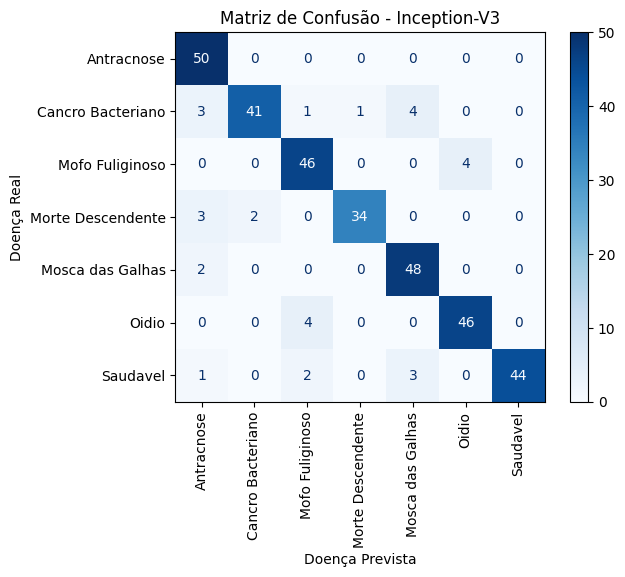

<Figure size 1000x800 with 0 Axes>

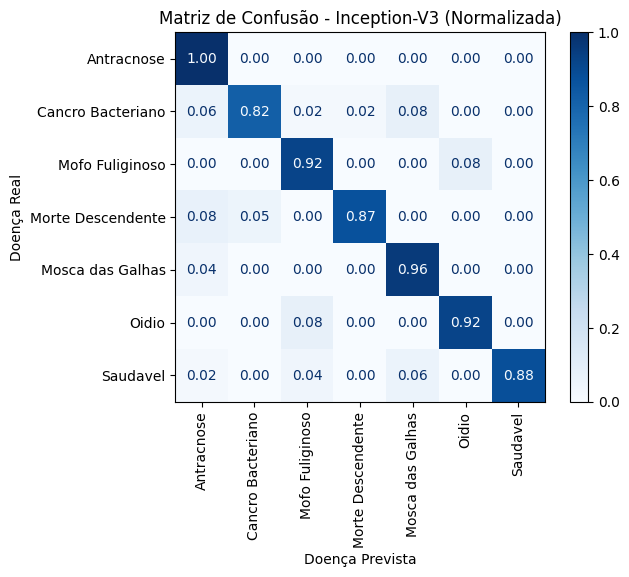

                   precision    recall  f1-score   support

       Antracnose       0.85      1.00      0.92        50
Cancro Bacteriano       0.95      0.82      0.88        50
  Mofo Fuliginoso       0.87      0.92      0.89        50
Morte Descendente       0.97      0.87      0.92        39
 Mosca das Galhas       0.87      0.96      0.91        50
            Oidio       0.92      0.92      0.92        50
         Saudavel       1.00      0.88      0.94        50

         accuracy                           0.91       339
        macro avg       0.92      0.91      0.91       339
     weighted avg       0.92      0.91      0.91       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/inceptionv3_fold_4.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Found 339 images belonging to 7 classes.
11/11 [==============================] - 8s 664ms/step


<Figure size 1000x800 with 0 Axes>

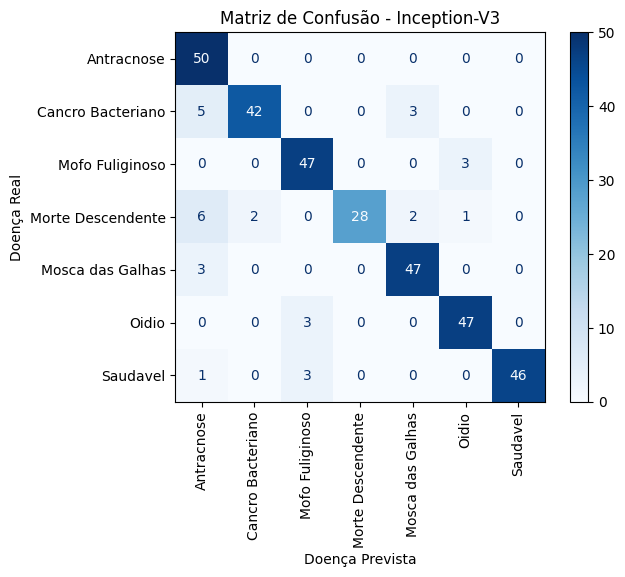

<Figure size 1000x800 with 0 Axes>

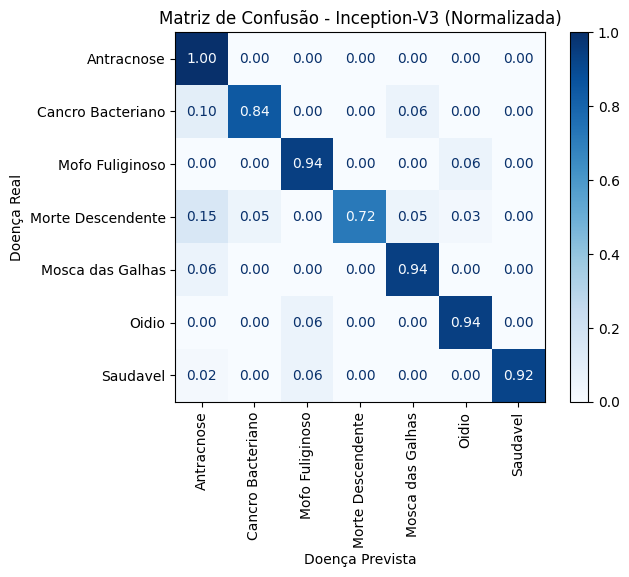

                   precision    recall  f1-score   support

       Antracnose       0.77      1.00      0.87        50
Cancro Bacteriano       0.95      0.84      0.89        50
  Mofo Fuliginoso       0.89      0.94      0.91        50
Morte Descendente       1.00      0.72      0.84        39
 Mosca das Galhas       0.90      0.94      0.92        50
            Oidio       0.92      0.94      0.93        50
         Saudavel       1.00      0.92      0.96        50

         accuracy                           0.91       339
        macro avg       0.92      0.90      0.90       339
     weighted avg       0.92      0.91      0.91       339



In [ ]:
# Importe as bibliotecas necessárias
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
#from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import ConfusionMatrixDisplay

# Carregue o modelo treinado
trained_model = load_model("/content/inceptionv3_fold_5.h5")  # Certifique-se de ter o nome correto do arquivo do modelo salvo

# Defina o caminho para a pasta de teste
test_path = '/content/drive/MyDrive/Dataset/Teste'

# Crie um gerador de dados para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Faça previsões no conjunto de teste
y_pred = trained_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Crie a matriz de confusão
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plote a matriz de confusão não normalizada com valores absolutos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_mtx, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Inception-V3')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Plote a matriz de confusão normalizada com percentuais
plt.figure(figsize=(10, 8))
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(confusion_mtx_normalized, display_labels=class_labels).plot(include_values=True, cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusão - Inception-V3 (Normalizada)')
plt.xticks(rotation=90)  # Adicionando rotação aos rótulos do eixo x
plt.xlabel('Doença Prevista')
plt.ylabel('Doença Real')
plt.show()

# Exiba métricas de classificação
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [ ]:
import shutil

# Especifique os caminhos dos arquivos e pastas
caminho_origem = '/content/inceptionv3_fold_4.h5'
caminho_destino = '/content/drive/MyDrive/Modelos_Treinados_3'

# Mova o arquivo para o novo destino
shutil.move(caminho_origem, caminho_destino)

print(f"O arquivo foi movido de {caminho_origem} para {caminho_destino}")


O arquivo foi movido de /content/inceptionv3_fold_4.h5 para /content/drive/MyDrive/Modelos_Treinados_3


1/1 [==============================] - 0s 66ms/step


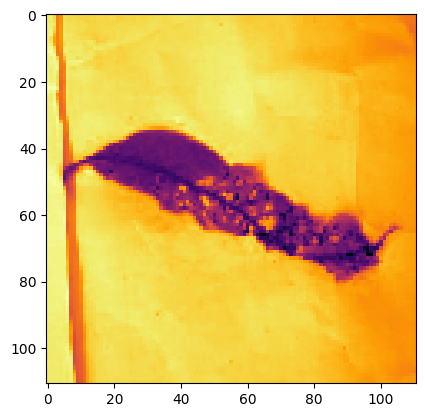

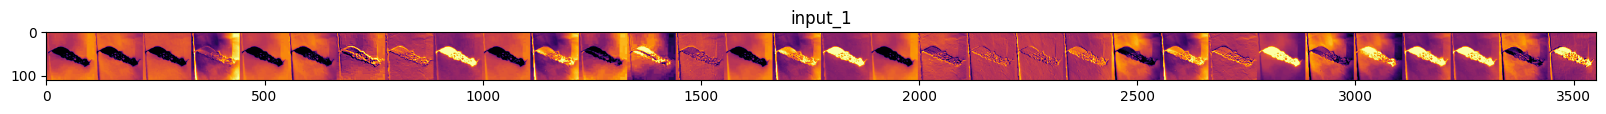

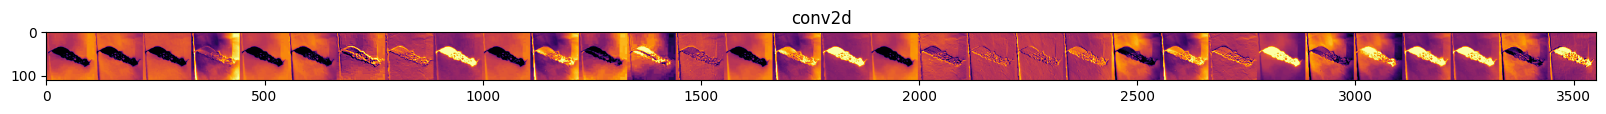

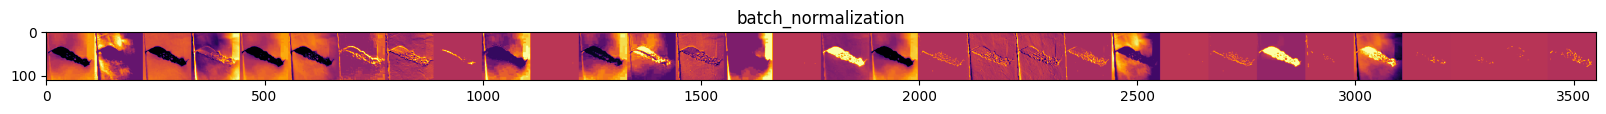

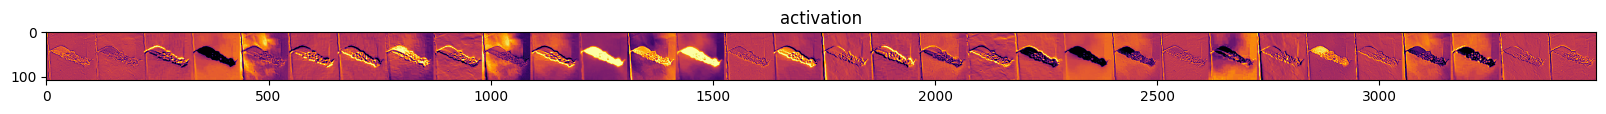

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Carregar o modelo InceptionV3 treinado
from keras.models import load_model
inceptionv3_model = load_model('/content/drive/MyDrive/Modelos_Treinados_3/inceptionv3_fold_4.h5')  # Substitua pelo caminho real do seu modelo

# Selecionar as camadas de interesse para visualização
successive_outputs = [layer.output for layer in inceptionv3_model.layers[1:5]]
visualization_model = Model(inputs=inceptionv3_model.input, outputs=successive_outputs)

# Carregar uma imagem de sua escolha
img_path = '/content/drive/MyDrive/Dataset/Antracnose/20211008_125014 (Custom).jpg'  # Substitua pelo caminho real da sua imagem
img = load_img(img_path, target_size=(224, 224))  # Imagem PIL

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x = preprocess_input(x)

# Visualizar as camadas
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in visualization_model.layers]

# Escolha do número da convolução a ser visualizada
CONVOLUTION_NUM = 1

# Visualização da ativação da camada escolhida
layer_activation = successive_feature_maps[0]
plt.imshow(layer_activation[0, :, :, CONVOLUTION_NUM], cmap='inferno')
plt.show()

# Visualização de todas as camadas
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size: (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='inferno')

plt.show()

1/1 [==============================] - 0s 69ms/step


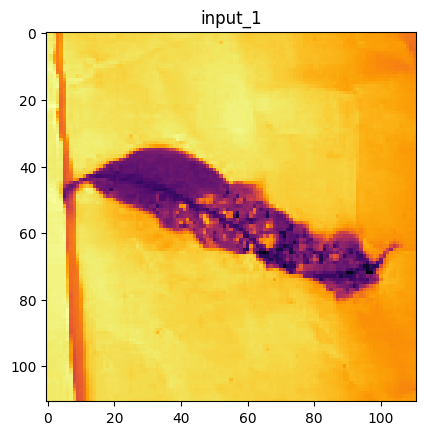

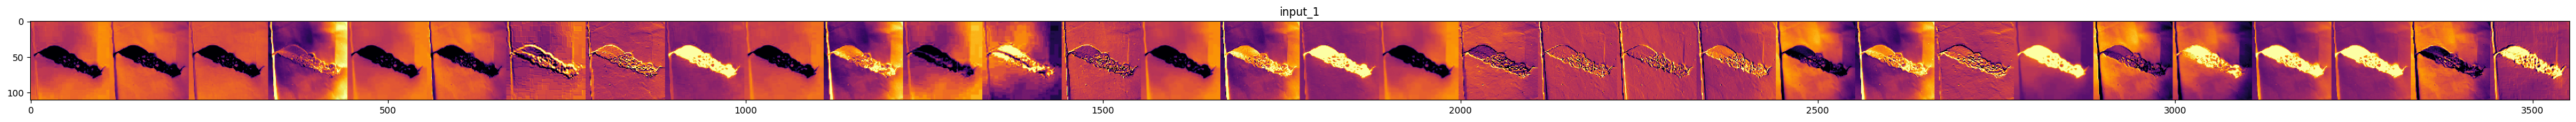

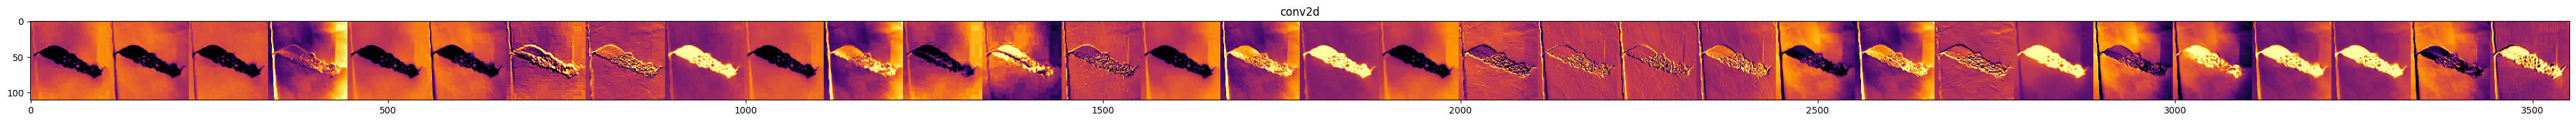

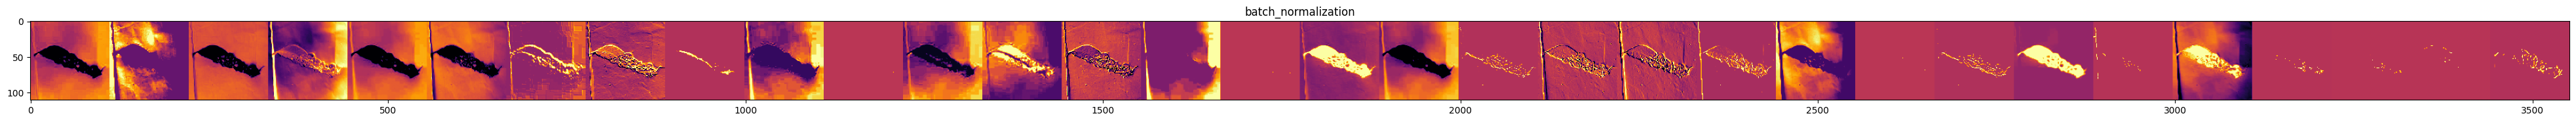

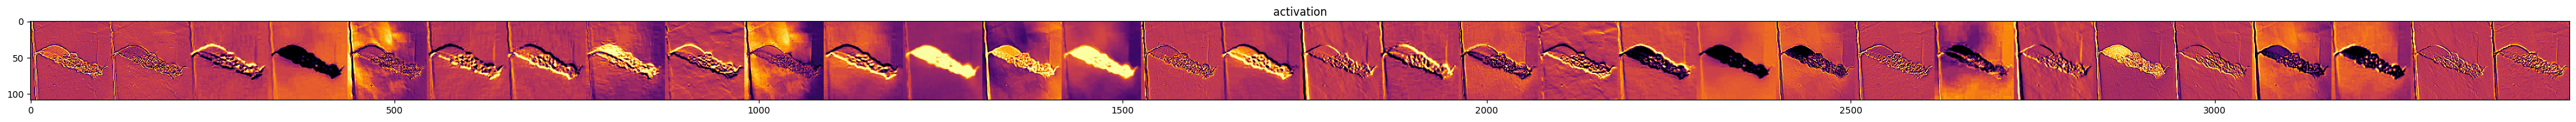

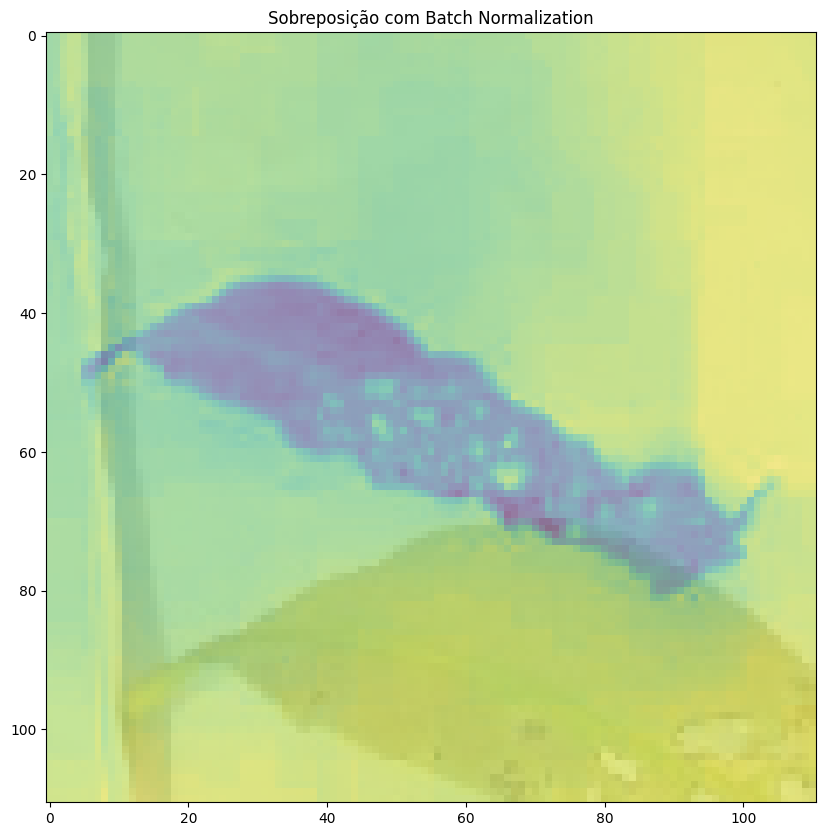

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Carregar o modelo InceptionV3 treinado
from keras.models import load_model
inceptionv3_model = load_model('/content/drive/MyDrive/Modelos_Treinados_3/inceptionv3_fold_4.h5')  # Substitua pelo caminho real do seu modelo

# Obter a camada de batch normalization
batch_norm_layer = None
for layer in inceptionv3_model.layers:
    if 'batch_normalization' in layer.name:
        batch_norm_layer = layer
        break

if batch_norm_layer is None:
    raise ValueError("Camada de batch normalization não encontrada no modelo.")

# Selecionar as camadas de interesse para visualização
successive_outputs = [layer.output for layer in inceptionv3_model.layers[1:5]]
visualization_model = Model(inputs=inceptionv3_model.input, outputs=successive_outputs + [batch_norm_layer.output])

# Carregar uma imagem de sua escolha
img_path = '/content/drive/MyDrive/Dataset/Antracnose/20211008_125014 (Custom).jpg'  # Substitua pelo caminho real da sua imagem
img = load_img(img_path, target_size=(224, 224))  # Imagem PIL

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x = preprocess_input(x)

# Visualizar as camadas
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in visualization_model.layers]

# Escolha do número da convolução a ser visualizada
CONVOLUTION_NUM = 1

# Visualização da ativação da camada escolhida
layer_activation = successive_feature_maps[0]
plt.imshow(layer_activation[0, :, :, CONVOLUTION_NUM], cmap='inferno')
plt.title(layer_names[0])
plt.show()

# Visualização de todas as camadas
for i, (layer_name, feature_map) in enumerate(zip(layer_names, successive_feature_maps[:-1])):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))

        for j in range(n_features):
            x = feature_map[0, :, :, j]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, j * size: (j + 1) * size] = x

        scale = 50. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='inferno')

# Sobrepor as figuras com a saída da camada de batch normalization
batch_norm_output = successive_feature_maps[-1][0, :, :, 0]
plt.figure(figsize=(10, 10))
plt.imshow(img, alpha=0.5)  # Sobrepor a imagem de entrada
plt.imshow(batch_norm_output, cmap='viridis', alpha=0.5)  # Sobrepor a saída da camada de batch normalization
plt.title("Sobreposição com Batch Normalization")
plt.show()
